In [1]:
import gym
import haiku as hk
import jax
import jax.numpy as jnp
import jax.nn as nn
import jax.random as random
import numpy as np
import optax
import matplotlib.pyplot as plt
import pickle as pkl
import sys
from jax import tree_map
from jax import grad, vjp, value_and_grad
from jax import lax
from jax import jit
from tqdm import tqdm
%matplotlib inline 

In [2]:
def policy_fn(observation):
  mlp = hk.Sequential(
      [
       hk.Linear(20), nn.relu,
       hk.Linear(2)
      ]
  )
  return mlp(observation)

In [3]:

def val_fn(observation):
  mlp = hk.Sequential(
      [
       hk.Linear(64), nn.relu,
       hk.Linear(1)
      ]
  )
  return mlp(observation)

In [4]:
def train():
  
  # Define training configurations and problem parameters
  NUM_EPISODE = 2000
  GAMMA = 0.95
  BATCH = 2
  RECORD_INTERVAL = 20
  
  # random key generator
  rng = hk.PRNGSequence(0)
  
  # actor and critic networks
  actor = hk.without_apply_rng(hk.transform(policy_fn))
  critic = hk.without_apply_rng(hk.transform(val_fn))

  dummy_obs = jnp.array([0,0,0,0],dtype=jnp.float32)

  actor_params = actor.init(rng.next(), dummy_obs)
  critic_params = critic.init(rng.next(), dummy_obs)

  # make optimizers
  actor_opt = optax.adam(1e-4)
  critic_opt = optax.adam(1e-3)

  actor_opt_state = actor_opt.init(actor_params)
  critic_opt_state = critic_opt.init(critic_params)

  # actor-related functions
  @jit
  def actor_obj(params, obs, rand):
    logits = actor.apply(params, obs)
    action = lax.stop_gradient(random.categorical(rand,logits))
    return nn.log_softmax(logits)[action], action 
  
  @jit
  def update_actor(params, opt_state, gradient):
    updates, new_opt_state = actor_opt.update(gradient, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state
  
  @jit
  def accumulate_actor_grad(cum_grad, log_grad, tde, discount):
    new_cum_grad = tree_map(lambda cg, lg: cg + discount*tde*lg, cum_grad, log_grad)
    return new_cum_grad
  
  @jit
  def zero_tree(tree):
    return tree_map(lambda x: 0*x, tree)
  
  
  
  # critic-related functions
  @jit
  def critic_obj(params, obs, reward, next_obs, gamma):
    v_t = critic.apply(params, obs)
    target = reward + gamma*critic.apply(params, next_obs)
    td_error = lax.stop_gradient(target) - v_t
    return (td_error**2)[0], td_error
  @jit
  def update_critic(params, opt_state, gradient):
    updates, new_opt_state = critic_opt.update(gradient, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

  # environment
  env = gym.make('CartPole-v0')
  env.seed(1)
  
  # record containers
  episode_lengths = []
  avg_tde = []

  for eps in tqdm(range(NUM_EPISODE)):
    # initialization for each episode
    o_t = jnp.array(env.reset(), dtype=jnp.float32)
    done = False
    I = 1.0
    cumulative_tde = 0
    num_step = 0
    cum_actor_grad = zero_tree(actor_params)
    
    while not done:
      likelihood_grad, action = grad(actor_obj, has_aux=True)(actor_params, o_t, rng.next())

      num_step += 1

      o_tp1, reward, done, _ = env.step(action.item())
      o_tp1 = jnp.array(o_tp1, dtype=jnp.float32)
      
      # update critic
      critic_grad, tde = grad(critic_obj,has_aux=True)(critic_params, o_t, reward, o_tp1,GAMMA)
      cumulative_tde += abs(tde.item())
      critic_params, critic_opt_state = update_critic(critic_params, critic_opt_state, critic_grad)
      
      cum_actor_grad = accumulate_actor_grad(cum_actor_grad, likelihood_grad, tde.item(), I)
      # update actor
      if num_step % BATCH == 0:
        actor_params, actor_opt_state = update_actor(actor_params, actor_opt_state, cum_actor_grad)
        cum_actor_grad = zero_tree(cum_actor_grad)
      
      I = GAMMA*I
      o_t = o_tp1
    
    actor_params, actor_opt_state = update_actor(actor_params, actor_opt_state,cum_actor_grad)
    
    # recording
    if eps % RECORD_INTERVAL == 0:
      episode_lengths.append(num_step)
      avg_tde.append(cumulative_tde/num_step)
    
  # save models
  with open('actor_param.pickle','wb') as fp:
    pkl.dump(actor_params, fp)

  with open('critic_param.pickle','wb') as fp:
    pkl.dump(critic_params, fp)
  
  return episode_lengths, avg_tde
 

  

In [5]:
def plot_figure(episode_lengths, avg_tde):
  plt.figure()
  plt.plot(episode_lengths,'b')
  plt.xlabel('episode/interval')
  plt.ylabel('length')
  plt.grid()
  
  plt.figure()
  plt.plot(avg_tde,'r')
  plt.xlabel('episode/interval')
  plt.ylabel('TD-error')
  plt.grid()

In [6]:
def test(episodes, render=False):
  GAMMA = 0.95
  # load parameters
  with open('actor_param.pickle','rb') as fp:
    actor_params = pkl.load(fp)
  with open('critic_param.pickle','rb') as fp:
    critic_params = pkl.load(fp)
  
  # create actor and critic
  actor = hk.without_apply_rng(hk.transform(policy_fn))
  critic = hk.without_apply_rng(hk.transform(val_fn))
  
  rng = hk.PRNGSequence(0)
  
  def act(obs, rng):
    logits = actor.apply(actor_params, obs)
    return random.categorical(rng, logits=logits).item()
  
  def pred(obs):
    return critic.apply(critic_params, obs).item()
  # make environment
  env = gym.make('CartPole-v0')
  env.seed(0)
  
  eps_lengths = []
  avg_tdes = []
  for eps in range(episodes):
    o_t = jnp.array(env.reset())
    done = False
    num_steps = 0
    total_tde = 0
    while not done:
      action = act(o_t, rng.next())
      
      o_tp1, reward, done, _ = env.step(action)
      num_steps += 1
      
      if render:
        env.render()
      
      total_tde += reward + GAMMA*pred(o_tp1) - pred(o_t)
      
      o_t = o_tp1
      
    
    eps_lengths.append(num_steps)
    avg_tdes.append(total_tde/num_steps)
  
  env.close()
  return eps_lengths, avg_tdes

In [7]:
def main():
  eps_len, avg_tde = train()
  plot_figure(eps_len, avg_tde)
  eps_len, avg_tde = test(100)
  plot_figure(eps_len, avg_tde)

100%|███████████████████████████████████████| 2000/2000 [09:50<00:00,  3.39it/s]


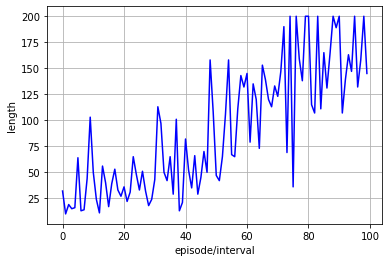

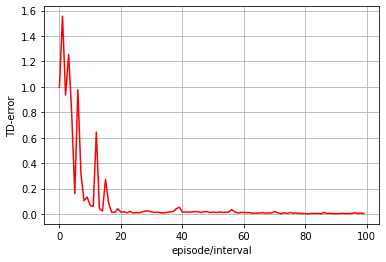

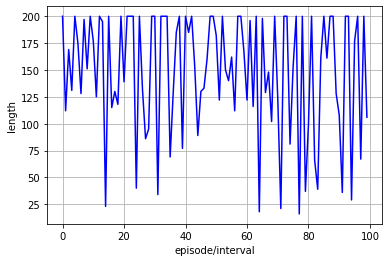

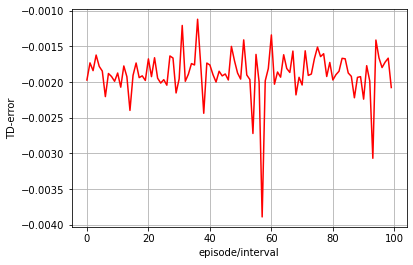

In [8]:
main()